In [1]:
import numpy as np

import matplotlib.pyplot as plt

from data_retrieval import seizure_timestamps, classify, seizurevector_retrieval

from nonseizure_dataretrieval import non_seizure_retrieval

In [3]:
with open('../chbmit/1.0.0/RECORDS', 'r') as f:
    recordlines = f.readlines()
    
with open('../chbmit/1.0.0/RECORDS-WITH-SEIZURES', 'r') as f:
    seizurelines = f.readlines()
    seizurelines = [line[6:].strip() for line in seizurelines]
    
summaries = []
for x in range(1, 25):
    if x < 10:
        x = f'0{x}'
    with open(f'../chbmit/1.0.0/chb{x}/chb{x}-summary.txt', 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines[29:]]
        summaries += lines

In [4]:
timestamps = seizure_timestamps(summaries, seizurelines)

In [5]:
seizureclass = np.zeros((197, 100))

In [24]:
Y = classify(seizureclass, timestamps)

In [37]:
X, classifierpop = seizurevector_retrieval(timestamps, channel1=0, channel2=3)

 44%|████▍     | 62/141 [01:25<03:27,  2.62s/it]

index 927744 is out of bounds for axis 1 with size 927744


 96%|█████████▋| 136/141 [03:05<00:05,  1.01s/it]

index 921600 is out of bounds for axis 1 with size 921600


 99%|█████████▊| 139/141 [03:07<00:01,  1.30it/s]

index 921600 is out of bounds for axis 1 with size 921600


 99%|█████████▉| 140/141 [03:07<00:00,  1.62it/s]

index 921600 is out of bounds for axis 1 with size 921600


100%|██████████| 141/141 [03:08<00:00,  1.34s/it]


In [38]:
Y = np.delete(Y, classifierpop, axis=0)

In [39]:
path = 'nonseizure.csv'
X_noseize, classiferpop = non_seizure_retrieval(seizurelines, path, i1=0, i2=3)

31it [00:30,  1.03it/s]


In [43]:
classifierpop

[61, 135, 138, 139]

In [41]:
X = np.concatenate((X, X_noseize))
classify_noseize = np.zeros((31, 100))
# classify_noseize = np.delete(classify_noseize, classifierpop, axis=0)
Y = np.concatenate((Y, classify_noseize))

In [42]:
print(f'Logits Shape: {X.shape}, Labels Shape: {Y.shape}')

Logits Shape: (224, 100, 24), Labels Shape: (251, 100)


In [265]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, TrueNegatives, FalseNegatives

In [266]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.add(Dropout(0.2))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy', 'TruePositives', 'FalsePositives', 'Precision', 'Recall'])
    return model

In [267]:
n_samples = 10
n_timesteps = 100
n_features = 22 * 8
model = create_RNN(2, n_timesteps, (n_timesteps, n_features), activation=['tanh', 'sigmoid'])

In [268]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42, shuffle=True)

In [269]:
model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
4/4 [==============================] - 1s 20ms/step - loss: 2.9462 - binary_accuracy: 0.7014 - true_positives: 7486.0000 - false_positives: 1530.0000 - precision: 0.8303 - recall: 0.8049
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 2.9732 - binary_accuracy: 0.6997 - true_positives: 7465.0000 - false_positives: 1528.0000 - precision: 0.8301 - recall: 0.8027
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 2.9828 - binary_accuracy: 0.6992 - true_positives: 7457.0000 - false_positives: 1526.0000 - precision: 0.8301 - recall: 0.8018
Epoch 4/100
4/4 [==============================] - 0s 25ms/step - loss: 3.0573 - binary_accuracy: 0.6948 - true_positives: 7400.0000 - false_positives: 1518.0000 - precision: 0.8298 - recall: 0.7957
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 3.0266 - binary_accuracy: 0.6959 - true_positives: 7423.0000 - false_positives: 1529.0000 - precision: 0.8292 - recall: 0.7982
Epoch

In [270]:
model.evaluate(X_test, Y_test)

4/4 [==============================] - 1s 7ms/step - loss: 0.4995 - binary_accuracy: 0.8848 - true_positives: 9910.0000 - false_positives: 1290.0000 - precision: 0.8848 - recall: 1.0000


[0.49948757886886597,
 0.8848214149475098,
 9910.0,
 1290.0,
 0.8848214149475098,
 1.0]

In [284]:
ypred = model.predict(X_test)
print(f'Original Shape: {ypred.shape}')

Original Shape: (112, 100)


In [285]:
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf

In [286]:
scaler = MinMaxScaler()
ypred = scaler.fit_transform(ypred.reshape(-1,1))

In [287]:
ypred = np.float64((ypred > 0.5))

In [299]:
cf_matrix = confusion_matrix(ypred, Y_test.reshape(-1,1))

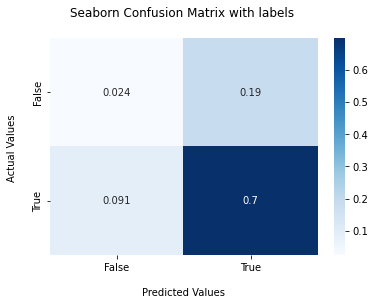

In [300]:
import seaborn as sns

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values \n ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()